# 🔁 10d - Multi-Output Forecast for All Features (Last Week of 2019)

This notebook performs **multi-output forecasting** for all energy-related features,
predicting the entire last week of 2019 (168 hours) in a single model run **per feature**
using `MultiOutputRegressor(XGBRegressor)`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

# Add ratio features
df['solar_load_ratio'] = df['DE_solar_generation_actual'] / df['DE_load_actual_entsoe_transparency']
df['wind_load_ratio'] = df['DE_wind_generation_actual'] / df['DE_load_actual_entsoe_transparency']

## 📦 Step 1: Prepare windowed training data for all features

📈 Processing: DE_solar_generation_actual


C:\Users\iTECH\AppData\Local\Temp\ipykernel_15520\614409582.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')


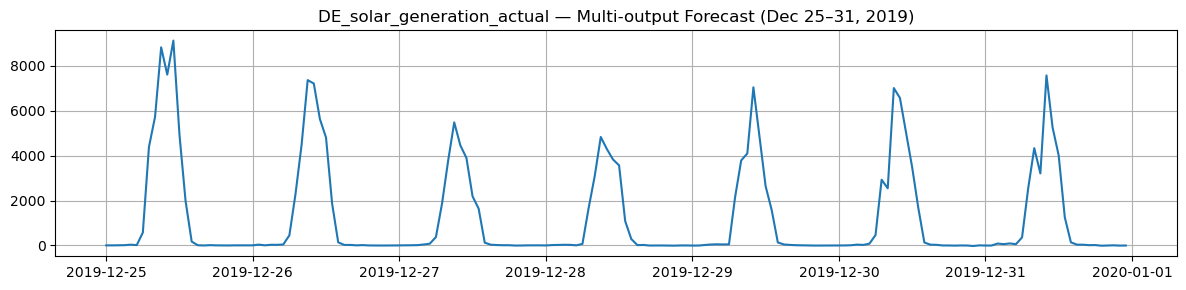

📈 Processing: DE_wind_generation_actual


KeyboardInterrupt: 

In [2]:
# Forecast settings
forecast_horizon = 168  # 1 week
input_lag = 168

# Features to forecast
targets = [
    'DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency',
    'Gas_Price', 'Oil_Price', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal',
    'DE_temperature', 'solar_load_ratio', 'wind_load_ratio'
]

# Initialize container for all forecasts
all_forecasts = {}

for feature in targets:
    print(f'📈 Processing: {feature}')
    series = df[feature].dropna()
    X, Y = [], []

    for i in range(input_lag, len(series) - forecast_horizon):
        X.append(series.iloc[i - input_lag:i].values)
        Y.append(series.iloc[i:i + forecast_horizon].values)

    X = np.array(X)
    Y = np.array(Y)

    model = MultiOutputRegressor(XGBRegressor(n_estimators=100))
    model.fit(X, Y)

    # Forecast using the last known input_lag
    last_input = series.iloc[-input_lag:].values.reshape(1, -1)
    forecast = model.predict(last_input)[0]

    index = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')
    forecast_df = pd.DataFrame({feature: forecast}, index=index)
    all_forecasts[feature] = forecast_df

    # Plot
    plt.figure(figsize=(12, 3))
    plt.plot(forecast_df.index, forecast_df[feature], label='Forecast')
    plt.title(f'{feature} — Multi-output Forecast (Dec 25–31, 2019)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Combine and save
final_df = pd.concat(all_forecasts.values(), axis=1)
final_df.to_csv('../data/processed/multioutput_forecast_all_features_last_week_2019.csv')
print('✅ Saved all forecasts to processed folder.')

Training is taking too long and results were not promising. so aborted halfway </br>
Finished by Jad Akra on April 20th 2025